# MNIST digit reconstruction and generation with Restricted Boltzmann Machine
#### references: Fischer and Igel, 2012, An Introduction to Restricted Boltzmann Machines

In [1]:
# . . import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [2]:
if torch.cuda.is_available():  
    device = torch.device("cuda")  
else:  
    device = torch.device("cpu")      

#device = 'cpu'
# . . set the default precision
dtype = torch.float32

# . . use cudnn backend for performance
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [3]:
# . . hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.1

# . . the number of hidden nodes
num_hidden = 500

# . . the number of visible nodes: (28x28)
num_visible = 784

# . . number of steps in depe contrasive learning
num_steps = 5

# . .  data loader parameters
num_workers = 8
pin_memory = True

In [4]:
# . . load the MNIST dataset
# . . the training set
trainloader = DataLoader(
    datasets.MNIST('./data', 
    train=True, 
    download=True, 
    transform=transforms.Compose([transforms.ToTensor()])),
    batch_size = batch_size,
    num_workers = num_workers,
    pin_memory = pin_memory)

# . . the test set
testloader = DataLoader(
    datasets.MNIST('./data', 
    train=False, 
    download=True, 
    transform=transforms.Compose([transforms.ToTensor()])),
    batch_size = batch_size,
    num_workers = num_workers,
    pin_memory = pin_memory)    

In [5]:
num_images = len(datasets.MNIST('./data', 
    train=True, 
    download=True, 
    transform=transforms.Compose([transforms.ToTensor()])))

### define the Restricted Boltzmann Machine

In [6]:
# . . the Restricted Boltzmann Machine: an energy-based model
# . . a restricted Boltzmann machine is a probabilistic graphical model
class RBM(nn.Module):
    def __init__(self, num_visible=784, num_hidden=500, k=5, device='cuda'):
        super(RBM, self).__init__()

        # . . the weight matrix
        self.W = nn.Parameter(torch.randn(num_hidden, num_visible) * 1e-2)
        # . . the bias of the hidden nodes
        self.bias_h = nn.Parameter(torch.zeros(num_hidden))
        # . . the bias of the visible nodes
        self.bias_v = nn.Parameter(torch.zeros(num_visible))
        # . . number of k-steps for contrasive divergence
        self.k = k  

        # . . cpu or gpu
        self.device = device


    # . . sample from a distribution
    def sample_from_distribution(self, p):
        return F.relu(torch.sign(p - torch.rand(p.size()).to(self.device)))

    # . . the Gibbs sampling
    # . . compute the probability of the hidden nodes given the visible nodes
    def sample_hidden(self, v):
        # . . the probability of the hidden node will be activated given the visible node
        prob_hidden = F.sigmoid(F.linear(v, self.W, self.bias_h))

        # . . draw a binary random number (0 or 1) from a Bernoulli distribution
        # . . to decide whether to activate the hidden neuron or not according to its probability
        sample_hidden = self.sample_from_distribution(prob_hidden)

        return prob_hidden, sample_hidden

    # . . compute the probability of the visible nodes given the hidden nodes
    def sample_visible(self, h):        
        # . . the probability of the hidden will be activated node given the visible node
        prob_visible = F.sigmoid(F.linear(h, self.W.t(), self.bias_v))

        # . . draw a binary random number (0 or 1) from a Bernoulli distribution
        # . . to decide whether to activate the visible neuron or not according to its probability
        sample_visible = self.sample_from_distribution(prob_visible)

        return prob_visible, sample_visible

    def forward(self, v):
        
        _, hk = self.sample_hidden(v)

        # . . k-step contrasive divergence
        for _ in range(self.k):
            _, vk = self.sample_visible(hk)
            _, hk = self.sample_hidden(vk)
            
            
        return v, vk

    def free_energy(self,v):
        vbias_term = v.mv(self.bias_v)
        wx_b = F.linear(v,self.W,self.bias_h)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()


In [7]:
# . . instantiate the model
rbm = RBM(num_visible, num_hidden, num_steps)
rbm = rbm.to(device)

### train the model

In [8]:
optimizer = optim.SGD(rbm.parameters(), lr=learning_rate)

In [11]:
# . . train the RBM with the k-step contrasive divergence
# . . the contrasive divergence approximates the log likelihood gradient
# . . we are updating weights to minimazie the energy (i.e., maximize the log likelihood)

for epoch in range(num_epochs):
    losses = []
    for _, (data,target) in enumerate(trainloader):        
        data = data.view(-1,784)
        sample_data = data.bernoulli()
        sample_data = sample_data.to(device)
        
        v,v1 = rbm(sample_data)

        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: {} Train Loss: {:.4f}".format(epoch, np.mean(np.abs(losses))))

Epoch 0 Train Loss: 2.9019
Epoch 1 Train Loss: 2.8207
Epoch 2 Train Loss: 2.8412
Epoch 3 Train Loss: 2.7266
Epoch 4 Train Loss: 2.6981
Epoch 5 Train Loss: 2.7362
Epoch 6 Train Loss: 2.7105
Epoch 7 Train Loss: 2.7948
Epoch 8 Train Loss: 2.7062
Epoch 9 Train Loss: 2.6395


### plot the features: image generation

In [12]:
def plot_features(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

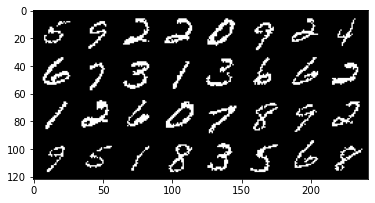

In [14]:
plot_features("real",make_grid(v.cpu().view(32,1,28,28).data))


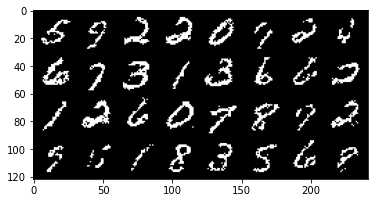

In [15]:
plot_features("generated",make_grid(v1.cpu().view(32,1,28,28).data))

### classification on the test dataset: single batch

In [16]:
# . . extract the features for the classification training
images, train_labels = next(iter(trainloader))
images = images.to(device)
images = images.view(-1,784)
images = images.bernoulli()

# . . predict features
_, train_features = rbm(images)


In [17]:
# . . extract the features for the classification test
images, test_labels = next(iter(testloader))
images = images.to(device)
images = images.view(-1,784)
images = images.bernoulli()

# . . predict features
_, test_features = rbm(images)

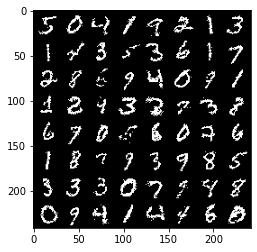

In [21]:
plot_features("training",make_grid(train_features.cpu().view(64,1,28,28).data))

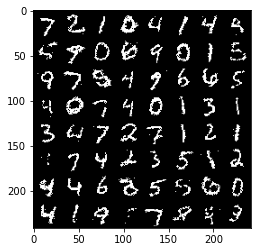

In [22]:
plot_features("test",make_grid(test_features.cpu().view(64,1,28,28).data))

In [23]:
# . . prepare the training and test features/labels for the Logistic regression
train_features = train_features.detach().cpu().numpy()
test_features  = test_features.detach().cpu().numpy()
train_labels = train_labels.numpy()
test_labels = test_labels.numpy()

In [24]:
# . . the logistic regressor for classification
classifier = LogisticRegression()

In [44]:
classifier.fit(train_features, train_labels)

LogisticRegression()

In [45]:
predictions = classifier.predict(test_features)

In [46]:
# . . compute the accuracy metric
def accuracy(outputs, targets):
    return np.mean(outputs == targets)  

In [47]:
labels = test_labels.reshape(batch_size,-1)
predictions = predictions.reshape(batch_size,-1)

In [48]:
acc = accuracy(predictions, labels)
print("Classification accuracy: {:4f}".format(acc))

Classification accuracy: 1.000000
